In [1]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pyt_model_class import Model_class
gpu_id = 1
!nvidia-smi

Sun Aug  1 20:59:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   25C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 34%   64C    P5    13W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
my_path = '../../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data,_ = torch.utils.data.dataset.random_split(images,[8000,1000,959,9500])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

root_dir = 'LatestSavedModels/'


9733
9726
{'0_0': 0, '1_1': 1}


# second model of squeeze net

In [3]:
sq_11 = torchvision.models.squeezenet1_1(pretrained=True)
sq_11.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)
# print(sq_11)

In [4]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=sq_11.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.1)
n_epochs=50

model = Model_class(sq_11,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 723522

epoch:[1/50],memory:[0.8774938583374023/10.91650390625], lr:[0.0003]
train_accuracy:0.5593501984600037, train_loss:0.696481242066338
val_acc:0.5960711058643129,val_loss:0.6711616632011201

epoch:[2/50],memory:[0.8767890930175781/10.91650390625], lr:[0.0003]
train_accuracy:0.6307043650793651, train_loss:0.6524922644335126
val_acc:0.6483997586700652,val_loss:0.6472181810273064

one of the best validation acc found
epoch:[3/50],memory:[0.8767890930175781/10.91650390625], lr:[0.0003]
train_accuracy:0.6473462302533407, train_loss:0.6400652414276486
val_acc:0.6639304045173857,val_loss:0.6279931250545714

epoch:[4/50],memory:[0.8848915100097656/10.91650390625], lr:[0.0003]
train_accuracy:0.6559523809996862, train_loss:0.6319991052150726
val_acc:0.6557782308922874,val_loss:0.6307162476910485

epoch:[5/50],memory:[0.8848915100097656/10.91650390625], lr:[0.0003]
train_accuracy:0.6772569446336656, train_loss:0.6175715634747158
val_acc:0.6531740642256207,va

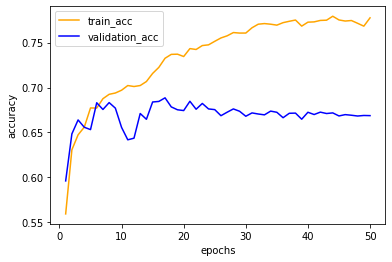

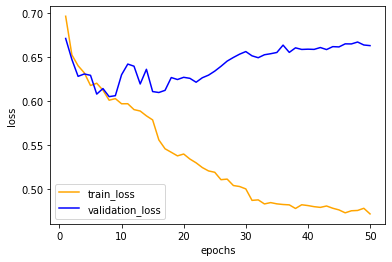

In [5]:
model.accuracy_curve()
model.loss_curve()

correct are 6112/8020
tensor(0.7621)


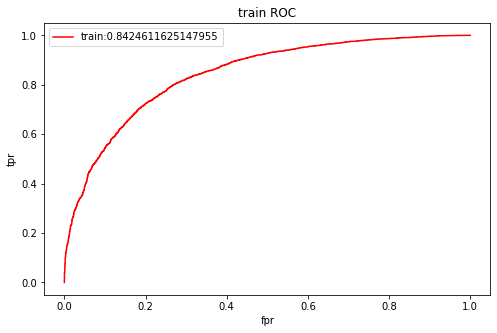

correct are 783/1146
tensor(0.6832)


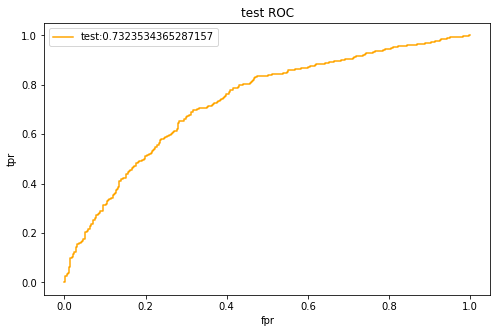

In [7]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


In [8]:
message = {'model':'squeeze_1_1',
          'changes':'sq_11.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)',
          'train_acc':0.7621,
          'test_acc':0.68}

model.save_model(directory = root_dir+'squeeze_1_1_v1.pth',message=message)
model.save_best_model(directory=root_dir+'squeeze_1_1_v1_best.pth',message=message)




model saved
model saved


# third passing the iteration of saved model for another 50 epochs

In [3]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
squeeze_1_0.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)

In [4]:
checkpoint2 = torch.load('saved_models/squeeze_1_0_test_69.5_auc_76.pth')
checkpoint2.keys()

dict_keys(['model', 'message'])

In [5]:
squeeze_1_0.load_state_dict(checkpoint2['model'])

<All keys matched successfully>

In [6]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma=0.1)
n_epochs=50

model = Model_class(squeeze_1_0,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 736450

one of the best validation acc found
epoch:[1/50],memory:[1.5077924728393555/10.91650390625], lr:[0.0003]
train_accuracy:0.6900545637758951, train_loss:0.6010041849480735
val_acc:0.7075218906005224,val_loss:0.5851797627078162

epoch:[2/50],memory:[1.5166454315185547/10.91650390625], lr:[0.0003]
train_accuracy:0.7048859127930233, train_loss:0.5879506038294898
val_acc:0.7014266302188238,val_loss:0.5891567303074731

epoch:[3/50],memory:[1.5166454315185547/10.91650390625], lr:[0.0003]
train_accuracy:0.7027529761904762, train_loss:0.5856816584155673
val_acc:0.7012945347362094,val_loss:0.592837990158134

epoch:[4/50],memory:[1.5166454315185547/10.91650390625], lr:[0.0003]
train_accuracy:0.709771825680657, train_loss:0.5781060573127534
val_acc:0.6972939322392145,val_loss:0.5960495157374276

epoch:[5/50],memory:[1.5166454315185547/10.91650390625], lr:[0.0003]
train_accuracy:0.7105158732997047, train_loss:0.5752897567692257
val_acc:0.694142512149281,val_

KeyboardInterrupt: 

In [ ]:
model.accuracy_curve()
model.loss_curve()

In [ ]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


# sqeeze net for more points

In [3]:
squeeze_1_0 = torchvision.models.squeezenet1_0(pretrained=True)
squeeze_1_0.classifier[1] = nn.Conv2d(512,2,kernel_size=1,stride=1,padding=0)

In [4]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeeze_1_0.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
n_epochs=50

model = Model_class(squeeze_1_0,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 736450

one of the best validation acc found
epoch:[1/50],memory:[2.092973232269287/10.91650390625], lr:[0.0003]
train_accuracy:0.6182366618778715, train_loss:0.6740759392502685
val_acc:0.6557291666666667,val_loss:0.6310002942879994

one of the best validation acc found
epoch:[2/50],memory:[2.1018190383911133/10.91650390625], lr:[0.0003]
train_accuracy:0.6633522726854302, train_loss:0.6298152569638256
val_acc:0.671875,val_loss:0.6316640019416809

epoch:[3/50],memory:[2.1018190383911133/10.91650390625], lr:[0.0003]
train_accuracy:0.6714559931552548, train_loss:0.624288787712922
val_acc:0.6640625,val_loss:0.6341784656047821

epoch:[4/50],memory:[2.1018190383911133/10.91650390625], lr:[0.0003]
train_accuracy:0.6746621619780552, train_loss:0.6189922449901758
val_acc:0.665625,val_loss:0.6137941241264343

epoch:[5/50],memory:[2.1018190383911133/10.91650390625], lr:[0.0003]
train_accuracy:0.6782632062794158, train_loss:0.618062357759844
val_acc:0.6661458333333

KeyboardInterrupt: 

In [ ]:
model.accuracy_curve()
model.loss_curve()

In [ ]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


In [3]:
sq_10 = torchvision.models.squeezenet1_0(pretrained=True)

sq_10.classifier[1] = nn.Sequential(nn.Conv2d(512,128,kernel_size=1,stride=1,padding=0),
                                    nn.ReLU(inplace=True),
                                   nn.Conv2d(128,2,kernel_size=1,stride=1,padding=0))
sq_10

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [4]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=sq_10.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
n_epochs=40

model = Model_class(sq_10,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 801346

epoch:[1/40],memory:[0.9259047508239746/10.91650390625], lr:[0.0003]
train_accuracy:0.541125, train_loss:0.6896102194786071
val_acc:0.5013950901726881,val_loss:0.6996513605117798

epoch:[2/40],memory:[0.9264740943908691/10.91650390625], lr:[0.0003]
train_accuracy:0.525125, train_loss:0.6920331339836121
val_acc:0.5199032748738924,val_loss:0.6931474804878235

epoch:[3/40],memory:[0.9264740943908691/10.91650390625], lr:[0.0003]
train_accuracy:0.5015, train_loss:0.6931474804878235
val_acc:0.519066222012043,val_loss:0.6931474804878235

epoch:[4/40],memory:[0.9264740943908691/10.91650390625], lr:[0.0003]
train_accuracy:0.5015, train_loss:0.6931474804878235
val_acc:0.5182291666666666,val_loss:0.6931474804878235

epoch:[5/40],memory:[0.9264740943908691/10.91650390625], lr:[0.0003]
train_accuracy:0.5015, train_loss:0.6931474690437317
val_acc:0.5182291666666666,val_loss:0.6931474804878235

epoch:[6/40],memory:[0.9264740943908691/10.91650390625], lr:[0.000

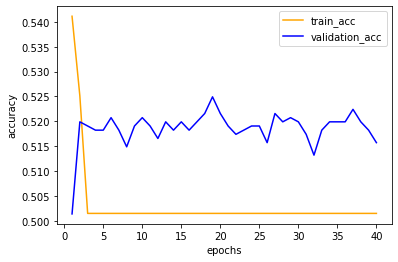

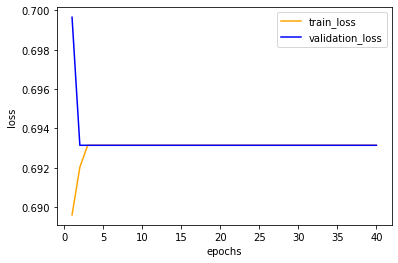

In [5]:
model.accuracy_curve()
model.loss_curve()

correct are 4012/8000
tensor(0.5015)


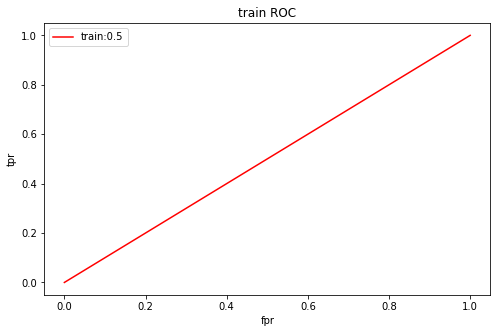

correct are 481/959
tensor(0.5016)


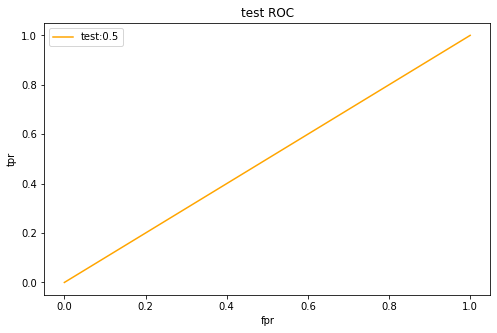

In [6]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


# squeezenet_merged_mobilenet

In [3]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation):

In [4]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeezenet.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=26,gamma=0.1)
n_epochs=60

model = Model_class(squeezenet,gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 134850

epoch:[1/60],memory:[1.302271842956543/10.91650390625], lr:[0.0003]
train_accuracy:0.5005, train_loss:0.6937526655197144
val_acc:0.5349609367549419,val_loss:0.6923089064657688

epoch:[2/60],memory:[1.3042411804199219/10.91650390625], lr:[0.0003]
train_accuracy:0.50925, train_loss:0.6928129410743713
val_acc:0.5119140632450581,val_loss:0.6904674246907234

epoch:[3/60],memory:[1.3042411804199219/10.91650390625], lr:[0.0003]
train_accuracy:0.527, train_loss:0.6854727959632874
val_acc:0.5523437522351742,val_loss:0.6815046072006226

epoch:[4/60],memory:[1.3042411804199219/10.91650390625], lr:[0.0003]
train_accuracy:0.581, train_loss:0.672372353553772
val_acc:0.5964843742549419,val_loss:0.6765081398189068

epoch:[5/60],memory:[1.3042411804199219/10.91650390625], lr:[0.0003]
train_accuracy:0.59475, train_loss:0.6674465198516846
val_acc:0.5783203132450581,val_loss:0.670441348105669

epoch:[6/60],memory:[1.3042411804199219/10.91650390625], lr:[0.0003]
tra

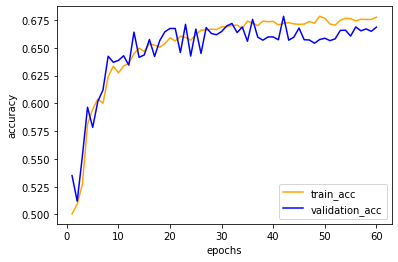

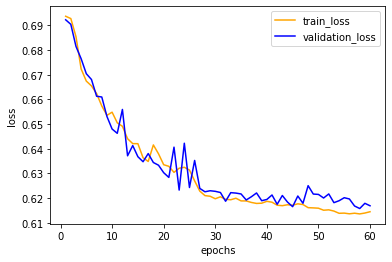

In [5]:
model.accuracy_curve()
model.loss_curve()

correct are 5399/8000
tensor(0.6749)


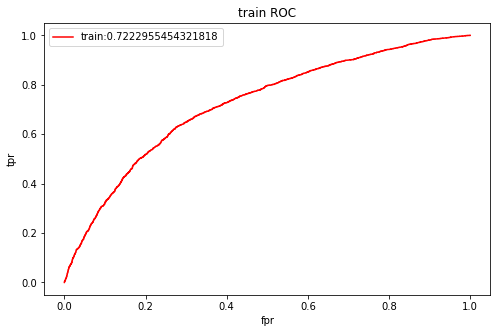

correct are 628/959
tensor(0.6548)


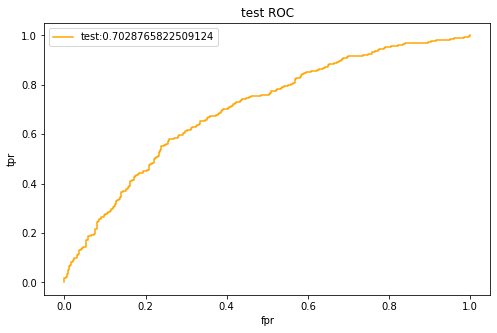

In [6]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(name='train',color='red')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(name='test',color='orange')


In [7]:
message = {'model':'squeeze_mobilenet'}

model.save_model(directory = root_dir+'squeeze_mob_v1.pth',message=message)
model.save_best_model(directory=root_dir+'squeeze_mob_v1_best.pth',message=message)

model saved
model saved
